In [1]:
import os
import sys
import pandas as pd
import datetime

import pathlib
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
import importlib


from tensorflow.keras import layers, losses
from tensorflow.keras.models import Model
from tensorflow import keras
from tensorflow.keras import callbacks  

# project specific
sys.path.append('../src')
from utils import data_handler
from utils import benchmark
from utils import visualisation

from utils.models import ConvVAE



import matplotlib.pyplot as plt
from tensorflow.python.ops.numpy_ops import np_config
np_config.enable_numpy_behavior()

import plotly.express as px
import plotly.subplots as sp
import plotly.graph_objs as go



%load_ext tensorboard
!rm -rf ../workfiles/logs/

not applying any filtering over phases
retaining all patient who have passed all visits...
loading samples...
loaded 1585 samples
retriving symbols for genes
removing 298 mithocondrial genes from the dataset
selecting genes based on median absolute deviation threshold:  5 ...
0.0
5012.2


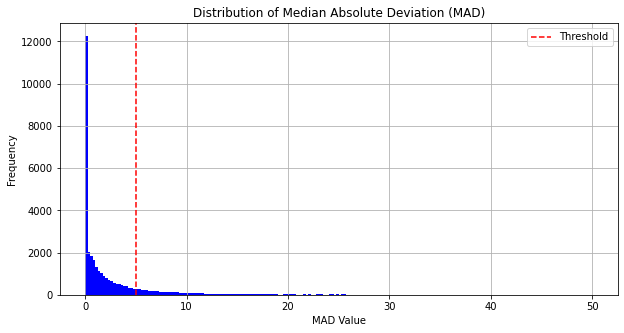

removing 28359 genes under the MAD threshold from the dataset
number of genes selected :  5912
log(1 + x) transformation...
scaling to [0, 1]...
number of seq in the dataset : 1585
converting samples to time series
number of actual individual to be studied : 317


In [2]:
importlib.reload(data_handler) # to allow modification of the script without restarting the whole session

absolute_path = "c:/thesis/data/quant"
metadata_path = "c:/thesis/METADATA_200123.xlsx"

x_train, filenames, n_genes, gene_names = data_handler.generate_dataset(
    #path = absolute_path,
    #metadata_path = metadata_path,
    retain_phases = None,
    feature_selection_threshold = 5, 
    normalization = False,
    as_time_series = True,
    MT_removal = True,
    log1p = True,
    min_max=True)

x_train._is_transpose = False
x_train._is_time_series = True

In [3]:
importlib.reload(ConvVAE) # to allow modification of the script without restarting the whole session

latent_dim = 32
sequence_length = 5
t_shape = (sequence_length, n_genes)


autoencoder = ConvVAE.generate_model(t_shape, latent_dim)
autoencoder.compile(optimizer='adam', loss=tf.keras.losses.MeanSquaredError())
autoencoder._name = "ConvVAE"

In [4]:
checkpoint_filepath = '../workfiles/simple_ae/checkpoint'
model_checkpoint_callback = callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights_only=True,
    monitor='loss',
    mode='min',
    save_best_only=True)


reduce_lr = callbacks.ReduceLROnPlateau(monitor='loss', factor=0.5,
                              patience=25, min_lr=0.00001)

early_stopping_callback = callbacks.EarlyStopping(monitor='loss', patience=50)


log_dir = "../workfiles/logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)

cb = [model_checkpoint_callback, 
      reduce_lr, 
      early_stopping_callback, 
      tensorboard_callback]

In [5]:
hist = autoencoder.fit(x_train, epochs=20, callbacks=cb)

Epoch 1/20


2023-09-07 18:38:45.848627: W tensorflow/tsl/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


5/5 [==============================] - 4s 698ms/step - loss: 7051.9828 - reconstruction_loss: 1.4706 - kl_loss: 10767.7686 - lr: 0.0010
Epoch 2/20
5/5 [==============================] - 2s 430ms/step - loss: 3379.1108 - reconstruction_loss: 0.2874 - kl_loss: 2132.1443 - lr: 0.0010
Epoch 3/20
5/5 [==============================] - 2s 511ms/step - loss: 433.3049 - reconstruction_loss: 0.2598 - kl_loss: 397.5391 - lr: 0.0010
Epoch 4/20
5/5 [==============================] - 2s 387ms/step - loss: 268.2063 - reconstruction_loss: 1.2425 - kl_loss: 267.4311 - lr: 0.0010
Epoch 5/20
5/5 [==============================] - 2s 372ms/step - loss: 314.4659 - reconstruction_loss: 2.1881 - kl_loss: 303.9235 - lr: 0.0010
Epoch 6/20
5/5 [==============================] - 2s 424ms/step - loss: 219.4577 - reconstruction_loss: 0.5217 - kl_loss: 224.0813 - lr: 0.0010
Epoch 7/20
5/5 [==============================] - 2s 358ms/step - loss: 222.9196 - reconstruction_loss: 1.3391 - kl_loss: 213.7148 - lr: 0.001

In [6]:
autoencoder.load_weights(checkpoint_filepath)

[10657.9736328125, 2145.54150390625, 398.4936218261719, 268.5975646972656, 306.6263732910156, 224.43844604492188, 215.21792602539062, 168.35108947753906, 152.5653839111328, 133.1403045654297, 119.09422302246094, 109.87684631347656, 99.81556701660156, 91.04080963134766, 84.57186889648438, 76.34580993652344, 69.6052017211914, 61.74691390991211, 54.18974685668945, 47.1379280090332]


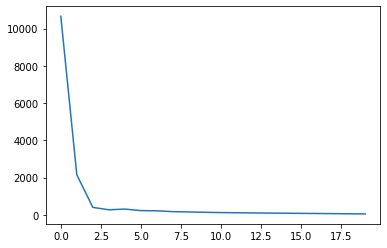

In [7]:
plt.plot(hist.history['loss'][0:])
print(hist.history['loss'])




benchmarking model : ConvVAE
number of parametters of the model: 3915264
shape of the dataset: (317, 5, 5912)
the dataset meets the min_max requirement
loss: 0.06597805
adding new performer to the history


,model_name,param_count,loss,obs_count,gene_number
0,FC_autoencoder,13522496,0.002833,NaN,NaN
1,FC_autoencoder,13522496,0.002833,NaN,NaN
2,FC_autoencoder,13522496,0.002833,NaN,NaN
3,FC_autoencoder,13522496,0.002826,NaN,NaN
4,FC_autoencoder,13522496,0.002810,NaN,NaN
5,FC_autoencoder,13522496,0.002810,NaN,NaN
6,FC_autoencoder,13522496,0.002810,NaN,NaN
7,FC_autoencoder,13522496,0.002810,5953.0,5953.0
8,FC_autoencoder,13522496,0.002810,2853.0,5953.0
9,FC_autoencoder,13522496,0.008133,2853.0,5953.0


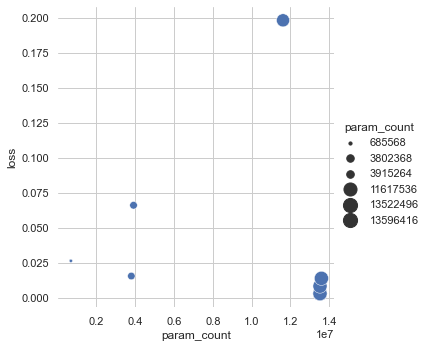

In [8]:
importlib.reload(benchmark) # to allow modification of the script without restarting the whole session
benchmark.benchmark(autoencoder, x_train, 0)

# diag

In [9]:
importlib.reload(visualisation) # to allow modification of the script without restarting the whole session
visualisation.plot_single_obs_processing(x_train, autoencoder)

In [10]:
e = iter(x_train).next()
_,__,z = autoencoder.encoder(e)
decoded = autoencoder.decoder(z)

e_ = e[0]  
z_ = z[0].reshape(1, -1) 
decoded_ = decoded[0]  


In [17]:
# more debugging 
print(e_.shape)
print(decoded_.shape)
print(sum(sum(e_))/(len(e_)))
print(sum(sum(decoded_))/len(decoded_))


(5, 5912)
(5, 5912)
tf.Tensor(3768.35, shape=(), dtype=float32)
tf.Tensor(2909.2517, shape=(), dtype=float32)


In [60]:
autoencoder.encoder.save('../workfiles/ConvVAE_model')


INFO:tensorflow:Assets written to: ../workfiles/ConvVAE_model/assets


INFO:tensorflow:Assets written to: ../workfiles/ConvVAE_model/assets


In [61]:
_,__,compressed_dataframe = autoencoder.encoder.predict(x_train)

5/5 [==============================] - 0s 25ms/step


In [62]:
reconstructed_dataframe = autoencoder.decoder.predict(compressed_dataframe)

10/10 [==============================] - 0s 12ms/step


In [64]:
df = pd.DataFrame(compressed_dataframe)
df["name"] = filenames["name"]

In [65]:
df.to_csv("../workfiles/compressed_data_ConvVAE.csv", index = False)


# viz


10/10 [==============================] - 0s 7ms/step


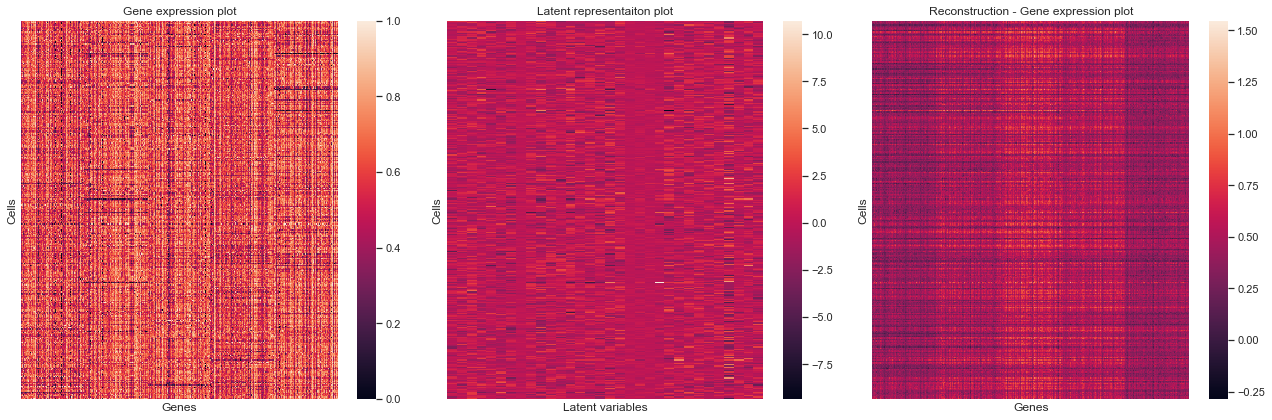

In [18]:
importlib.reload(visualisation) # to allow modification of the script without restarting the whole session
visualisation.plot_dataset_processing(x_train, autoencoder)